In [2]:
import kmodels as kmk
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd
import dask.array as da
from torch.nn import functional as F
import pickle
import gc

c:\Users\efons\anaconda3\envs\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def split_df_into_subjects(df):
    subject_names = df['Subject'].unique()
    return [df[df['Subject'] == subject] for subject in subject_names]

def split_subject_df(subject_df):
    # get the time column for the subject
    time = subject_df['Time'].values
    # get the indices where the time resets to its minimum value
    time_splits = np.where(time == time.min())[0]
    # split the subject index into events
    subject_events = np.split(subject_df.index, time_splits)
    # get rid of the empty lists in the list of lists
    subject_events = [i for i in subject_events if len(i) > 0]
    # return the list of events
    return [subject_df.loc[event] for event in subject_events]

def sliding_event_df(event_df, window_size, stride):
    # get the number of rows in the event
    num_rows = event_df.shape[0]
    # get the number of windows in the event
    num_windows = (num_rows - window_size) // stride + 1
    # get the indices of the windows
    window_indices = [np.arange(i, i + window_size) for i in range(0, num_windows * stride, stride)]
    # return the list of windows
    return [event_df.iloc[window] for window in window_indices]

class Dataset_LSTM(torch.utils.data.Dataset):
    def __init__(self, df, window_size = 50, stride = 10, xcols = ['EPB', 'EPL', 'FPL', 'APL', 'ADD', 'FCU', 'FPB', 'OPP'], ycols = ['Fx','Fy','Fz'], sort_column=['Event','Subject']):
        self.df = df
        self.xcols = xcols
        self.ycols = ycols
        self.window_size = window_size
        self.stride = stride
        
        # get the subjects from the dataframe
        subjects = split_df_into_subjects(df)
        subject_events = [split_subject_df(subject) for subject in subjects]
        # for each event create a sliding window using the window size and stride
        subject_event_windows = [[sliding_event_df(event, window_size, stride) for event in subject] for subject in subject_events]
        # flatten the list of lists
        subject_event_windows = [window for subject in subject_event_windows for event in subject for window in event]
        self.x_windows = [window[xcols].values for window in subject_event_windows]
        self.y_windows = [window[ycols].values for window in subject_event_windows]
        # save X for an LSTM model. the X shape should be (num_windows, window_size, num_features)
        self.X = np.array([np.expand_dims(x, axis=0) for x in self.x_windows])
        self.X = self.X.reshape(self.X.shape[0], self.X.shape[2], self.X.shape[3])
        # save Y for an LSTM model. the Y shape should be (num_windows, window_size, num_features)
        self.Y = np.array([np.expand_dims(y, axis=0) for y in self.y_windows])
        self.Y = self.Y.reshape(self.Y.shape[0], self.Y.shape[2], self.Y.shape[3])
        # save the number of windows
        self.num_windows = self.X.shape[0]
        # save the number of features
        self.num_features = self.X.shape[2]
        # save the number of outputs
        self.num_outputs = self.Y.shape[2]
        # save all the variables we used to the class
        self.subjects = subjects
        self.subject_events = subject_events
        self.subject_event_windows = subject_event_windows
        self.sort_column = sort_column
    
    def __len__(self):
        return self.num_windows
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
        
def split_df_into_subjects_dask(df):
    subject_names = df['Subject'].unique().compute()
    return [df[df['Subject'] == subject] for subject in subject_names]

def split_subject_df_dask(subject_df):
    # get the time column for the subject
    time = subject_df['Time'].values.compute()
    # get the indices where the time resets to its minimum value
    time_splits = np.where(time == time.min())[0]
    # split the subject index into events
    subject_events = da.split(subject_df.index.compute(), time_splits)
    # get rid of the empty lists in the list of lists
    subject_events = [i for i in subject_events if len(i) > 0]
    # return the list of events
    return [subject_df.loc[event] for event in subject_events]

def sliding_event_df_dask(event_df, window_size, stride):
    # get the number of rows in the event
    num_rows = event_df.shape[0].compute()
    # get the number of windows in the event
    num_windows = (num_rows - window_size) // stride + 1
    # get the indices of the windows
    window_indices = [da.arange(i, i + window_size) for i in range(0, num_windows * stride, stride)]
    # return the list of windows
    return [event_df.iloc[window] for window in window_indices]


# lets write a function that will plot the prediction of the model on a event dataframe from the dataclass 
def get_event_prediction(event_df, model, window_size = 100, stride=5, xcols = ['EPB', 'EPL', 'FPL', 'APL', 'ADD', 'FCU', 'FPB', 'OPP'], ycols = ['Fx','Fy','Fz'], device='cuda'):
    # get the number of rows in the event
    num_rows = event_df.shape[0]
    window_dfs = sliding_event_df(event_df, window_size = num_rows, stride = 1)
    # get the X and Y values for the event
    X = np.array([window[xcols].values for window in window_dfs])
    Y = np.array([window[ycols].values for window in window_dfs])
    # reshape the X and Y values for the model
    X = np.expand_dims(X, axis=0)
    X = X.reshape(X.shape[0], X.shape[2], X.shape[3])
    Y = np.expand_dims(Y, axis=0)
    Y = Y.reshape(Y.shape[0], Y.shape[2], Y.shape[3])
    # get the prediction from the model
    Y_pred = model(torch.tensor(X, dtype=torch.float32).to(device))
    # get the prediction and actual values from the tensors
    Y_pred = Y_pred.detach().cpu().numpy()
    # knowing the stride we know that the prediction is every stride number of rows
    # lets make a list of indexs to keep track of which windows belond to which time points
    window_indices = [i.index for i in window_dfs]
    # go into each window indicies and append the predicitnos to each dataframe Fx_pred, Fy_pred, Fz_pred
    window_dfs = [window_dfs[i].assign(Fx_pred = Y_pred[0][i][0], Fy_pred = Y_pred[0][i][1], Fz_pred = Y_pred[0][i][2]) for i in range(len(window_dfs))]
    window_merged = pd.concat(window_dfs)
    # take the mean of each index using the window indices
    event_df = window_merged.groupby(window_merged.index).mean()
    return window_dfs

def batch_predict(model, input, batch_size=500):
    n_batches = int(np.ceil(input.shape[0] / batch_size))
    for i in range(n_batches):
        gc.collect()
        torch.cuda.empty_cache()
        if i == 0:
            output = model(input[i*batch_size:(i+1)*batch_size]).detach().cpu()
        else:
            output = torch.cat((output, model(input[i*batch_size:(i+1)*batch_size]).detach().cpu())).detach().cpu()
    return output

In [4]:
class Dataset_LSTM_Parallel(torch.utils.data.Dataset):
    def __init__(self, df, window_size = 50, stride = 10, xcols = ['EPB', 'EPL', 'FPL', 'APL', 'ADD', 'FCU', 'FPB', 'OPP'], ycols = ['Fx','Fy','Fz'], sort_column=['Event','Subject']):
        self.df = dd.from_pandas(df, npartitions=4)
        self.xcols = xcols
        self.ycols = ycols
        self.window_size = window_size
        self.stride = stride
        self.sort_column = sort_column
        
        self.df = self.df.map_partitions(split_df_into_subjects, meta=(None,))
        self.df = self.df.map_partitions(split_subject_df, meta=(None,))
        self.df = self.df.map_partitions(lambda x: [sliding_event_df(event, window_size, stride) for event in x], meta=(None,))
        self.df = self.df.flatten()
        self.df = self.df.map(lambda x: x[xcols + ycols], meta=(None,))
        self.df = self.df.repartition(npartitions=4)
        
        self.X = da.stack([self.df[xcols].to_dask_array() for _, self.df in self.df.groupby(sort_column)], axis=0)
        self.X = self.X.reshape(-1, window_size, len(xcols))
        self.Y = da.stack([self.df[ycols].to_dask_array() for _, self.df in self.df.groupby(sort_column)], axis=0)
        self.Y = self.Y.reshape(-1, window_size, len(ycols))
        
        self.num_windows = self.X.shape[0]
        self.num_features = self.X.shape[2]
        self.num_outputs = self.Y.shape[2]
        
    def __len__(self):
        return self.num_windows
    
    def __getitem__(self, idx):
        return self.X[idx].compute(), self.Y[idx].compute()
    
class lstm(nn.Module):
    def __init__(self, n_inputs=8, hidden_size=30, n_outputs=300, n_linear_layers=1, 
                 layer_size=10, lstm_n_outputs=30):
        super().__init__()
        self.lstm = nn.LSTM(n_inputs, hidden_size, batch_first=True)
        self.fcs = nn.ModuleList([nn.Linear(layer_size, layer_size) for i in range(n_linear_layers)])
        self.layer_size = layer_size
        self.n_linear_layers = n_linear_layers 
        self.lstm_n_outputs = lstm_n_outputs
        self.output = nn.Linear(layer_size, n_outputs)
        
    def forward(self, x):
        rows = x.shape[0]
        x, _ = self.lstm(x)
        x = x.reshape(rows, -1)
        for i, fc in enumerate(self.fcs):
            if fc == self.fcs[0]:
                if x.shape[1] != int(fc.in_features):
                    try:    
                        self.fcs[0] = nn.Linear(x.shape[1], self.layer_size)
                        x = F.relu(self.fcs[0](x))
                    except:
                        self.fcs[0] = nn.Linear(x.shape[1], self.layer_size).to('cuda')
                        x = F.relu(self.fcs[0](x))
                else:
                    x = F.relu(fc(x))
            else:
                x = F.relu(fc(x))
        x = self.output(x)
        return x

In [5]:

class Dataset_LSTM(torch.utils.data.Dataset):
    def __init__(self, df, window_size = 50, stride = 10, xcols = ['EPB', 'EPL', 'FPL', 'APL', 'ADD', 'FCU', 'FPB', 'OPP'], ycols = ['Fx','Fy','Fz'], sort_column=['Event','Subject']):
        self.df = df
        self.xcols = xcols
        self.ycols = ycols
        # the window size represents how many samples to include in each window
        self.window_size = window_size
        # the stride represents how many samples to skip between windows
        self.stride = stride
        
        
        # make sure the df is ordered by subject
        self.df = self.df.sort_values(by=sort_column)
        self.df = self.df.reset_index(drop=True)
        self.subject_index = [i.values for i in self.df.groupby(sort_column).apply(lambda x: x.index)]
        self.subjects = list(self.df.groupby(sort_column).groups.keys())
        self.n_features = len(xcols)
        # sort the subject list index. self.subjects contains a list of indices for that belong to each subject. lets sort each list in ascending order
        # for each subject multiple trails are run. lets split them up and make a list of lists for each subject. The way we know a 
        # new event has started is when the time column resets to its minimum value.
        
        
        
        # split the subject index into events
        self.subject_events = []
        time_splits = []
        for subject in self.subject_index:
            # get the time column for the subject
            time = self.df.loc[subject]['Time'].values
            # get the indices where the time resets to its minimum value
            time_splits.append(np.where(time == time.min())[0])
            # split the subject index into events
            self.subject_events.append(np.split(subject, time_splits[-1]))
        # reorganize the dataframe in the order of subject_events
        self.df = pd.concat([pd.concat([self.df.loc[subject] for subject in event]) for event in self.subject_events])
        self.df = self.df.reset_index(drop=True)
        
        
        # remake subjects_events to be consistent with the new dataframe
        self.subject_events = []
        time_splits = []
        for subject in self.subject_index:
            # get the time column for the subject
            time = self.df.loc[subject]['Time'].values
            # get the indices where the time resets to its minimum value
            time_splits.append(np.where(time == time.min())[0])
            # split the subject index into events
            self.subject_events.append(np.split(subject, time_splits[-1]))
        # get rid of the empty lists in the list of lists
        self.subject_events = [[i for i in subject if len(i) > 0][0] for subject in self.subject_events]
        
        # for each subject we need to create a vector containig the indices for each window
        self.subject_windows = []
        for subject in self.subject_events:
            # get the number of windows for the subject
            n_windows = (len(subject) - self.window_size) // self.stride + 1
            # create a list of lists for the subject
            self.subject_windows.append([subject[i*self.stride:i*self.stride+self.window_size] for i in range(n_windows)])
        # get rid of the empty lists in the list of lists
        self.subject_windows = [[i for i in subject if len(i) > 0] for subject in self.subject_windows]
        # we should now be able to access the dataframe referencing the n-th frame of any subject using the __getitem__ method
        #self.subject_windows = np.concatenate(self.subject_windows)
        # reorganize self.subject_windows to be a single list of lists
        self.subject_windows = [i for subject in self.subject_windows for i in subject]
        # organize X for an LSTM model. The LSTM model expects the input to be in the shape (batch_size, seq_len, n_inputs)
        self.X = np.array([self.df.loc[window][self.xcols].values for window in self.subject_windows])
        self.X = self.X.reshape(-1, self.window_size, self.n_features)
        self.X = torch.from_numpy(self.X).float()
        
        # get the output
        self.Y = np.array([self.df.loc[window][self.ycols].values for window in self.subject_windows])
        self.Y  = torch.from_numpy(self.Y).float()
        self.Y = self.Y.view(self.X.shape[0], -1)
        self.X = self.X.to('cuda')
        self.Y = self.Y.to('cuda')
        return 
        
    
        
    def __getitem__(self, index):
        # the index is the index of the window in the subject_windows lis
        return self.df.loc[self.subject_windows[index]][self.xcols].values, self.df.loc[self.subject_windows[index]][self.ycols].values
    
    def __len__(self):
        return len(self.subject_index)

In [6]:
df = pd.read_pickle('../data/SeparatedData_MedFilt.pkl')
window_size = 100
stride = window_size
df

,Time,Event,EPB,EPL,FPL,APL,ADD,FCU,FPB,OPP,Fx,Fy,Fz,Subject
0,0.000000,0,0.298356,0.143422,0.271437,0.455853,0.445717,0.169887,0.216451,0.259434,-0.195990,-0.366495,0.366495,bXa12
1,0.024631,0,0.394776,0.201529,0.336203,0.588685,0.542767,0.169887,0.220666,0.327056,-0.187540,-0.370361,0.370361,bXa12
2,0.049261,0,0.437829,0.262160,0.397237,0.693981,0.636553,0.169887,0.226120,0.391021,-0.176207,-0.398903,0.398903,bXa12
3,0.073892,0,0.440273,0.321387,0.423438,0.696560,0.717565,0.169887,0.232679,0.447697,-0.189739,-0.391285,0.391285,bXa12
4,0.098522,0,0.444903,0.375241,0.424493,0.702552,0.719058,0.169887,0.239881,0.494490,-0.185666,-0.356704,0.356704,bXa12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,4.901151,2,0.258348,0.599492,0.991095,0.845696,0.750183,0.397436,0.701687,0.778256,-11.387135,-67.483305,67.483305,zNu44
608,4.925780,2,0.255153,0.599492,0.991095,0.845696,0.750183,0.404779,0.701687,0.778256,-11.355251,-67.445019,67.445019,zNu44
609,4.950409,2,0.251757,0.599492,0.991095,0.845696,0.742197,0.411974,0.701687,0.778256,-11.363783,-67.451038,67.451038,zNu44
610,4.975038,2,0.248169,0.599492,0.991095,0.845696,0.731769,0.418274,0.701687,0.778256,-11.271886,-67.532919,67.532919,zNu44


In [7]:
leave_out_df = df[df['Subject'] == 'RGr10']
train_df = df[df['Subject'] != 'RGr10']
train_data = Dataset_LSTM(train_df, window_size=window_size, stride=stride)
test_data = Dataset_LSTM(leave_out_df, window_size=window_size, stride=stride)

In [14]:
# lets make an autoencoder that will allow us to reduce the dimensionality of the data down to "n_dimensions"
# we also want to define n_inputs. 

class autoNN(nn.Module):
    def __init__(self, n_inputs=9, n_dimensions=3, n_layers=5):
        super(autoNN, self).__init__()
        self.n_inputs = n_inputs
        self.n_dimensions = n_dimensions
        self.n_layers = n_layers
        # lets set up the encoder so that the next linear layer is the next power of 2. Then we will 
        # use n_layers to determine the dimensions of the linear layers
        # find the closest power of 2 to n_inputs which is smaller
        self.first_layer_size = 2**int(np.log2(n_inputs))
        # use n_layers to determine the dimensions of the linear layers
        self.layer_sizes = [self.n_inputs, self.first_layer_size]
        self.layer_sizes = self.layer_sizes + [self.first_layer_size//2**i for i in range(1, n_layers-1)]
        # the first layer has n_inputs inputs and the last layer has n_dimensions outputs
        self.encoder = nn.ModuleList([nn.Linear(self.layer_sizes[i], self.layer_sizes[i+1]) for i in range(n_layers-1)])
        self.encoder[-1] = nn.Linear(self.layer_sizes[-2], self.n_dimensions)
        self.decoder = nn.ModuleList([nn.Linear(self.layer_sizes[::-1][i], self.layer_sizes[::-1][i+1]) for i in range(n_layers-1)])
        self.decoder[-1] = nn.Linear(self.layer_sizes[::-1][-2], self.n_inputs)
        self.decoder[0] = nn.Linear(self.n_dimensions, self.layer_sizes[::-1][1])
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # encode the input
        for layer in self.encoder:
            x = self.relu(layer(x))
        # decode the input
        for layer in self.decoder:
            x = self.relu(layer(x))
        return x

In [15]:
# lets make a new auto encoder that uses n_dim to make a n_layers with n_dim in the middle

class autoNN(nn.Module):
    def __init__(self, n_inputs=9, n_dimensions=3, n_layers=3):
        super(autoNN, self).__init__()
        self.n_inputs = n_inputs
        self.n_dimensions = n_dimensions
        self.n_layers = n_layers
        self.encoder = nn.ModuleList([nn.Linear(n_inputs, n_dimensions)])
        for i in range(n_layers-1):
            self.encoder.append(nn.Linear(n_dimensions, n_dimensions))
        self.decoder = nn.ModuleList([nn.Linear(n_dimensions, n_dimensions)])
        for i in range(n_layers-1):
            self.decoder.append(nn.Linear(n_dimensions, n_dimensions))
        self.decoder[-1] = nn.Linear(n_dimensions, n_inputs)
        
        
    
    def forward(self, x):
        # encode the input
        for layer in self.encoder:
            x = layer(x)
        # decode the input
        for layer in self.decoder:
            x = layer(x)
        return x
    
    def encode(self, x):
        for layer in self.encoder:
            x = layer(x)
        return x
    def decode(self, x):
        for layer in self.decoder:
            x = layer(x)
        return x

In [16]:
# make a function to compute any level of pascals triangle
def pascal_triangle(n):
    if n == 0:
        return [1]
    if n == 1:
        return [1, 1]
    else:
        # get the previous row
        prev_row = pascal_triangle(n-1)
        # make the new row
        new_row = [1]
        for i in range(len(prev_row)-1):
            new_row.append(prev_row[i] + prev_row[i+1])
        new_row.append(1)
        return new_row
    # test the function
pascal_triangle(5)


[1, 5, 10, 10, 5, 1]

In [25]:
test = autoNN(n_inputs=9, n_dimensions=3, n_layers=2)
test

autoNN(
  (encoder): ModuleList(
    (0): Linear(in_features=9, out_features=3, bias=True)
    (1): Linear(in_features=3, out_features=3, bias=True)
  )
  (decoder): ModuleList(
    (0): Linear(in_features=3, out_features=3, bias=True)
    (1): Linear(in_features=3, out_features=9, bias=True)
  )
)

In [26]:
#xcols = [EPB	EPL	FPL	APL	ADD	FCU	FPB	OPP]
from sklearn.preprocessing import StandardScaler
xcols = ['Time', 'EPB', 'EPL', 'FPL', 'APL', 'ADD', 'FCU', 'FPB', 'OPP']
ycols = ['Fx', 'Fy','Fz']
X = df[xcols].values.reshape(-1, 8)
Y = df[ycols].values.reshape(-1, 3)
# lets append X to Y so that we can use the autoencoder to reduce the dimensionality of the data
#X = np.concatenate((X, Y), axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)

X = torch.from_numpy(X).float()
Y = torch.from_numpy(Y).float()

In [27]:
model = autoNN(n_inputs=X.shape[1], n_dimensions=2, n_layers=3)
model = model.to('cuda')
model(X.to('cuda'))

tensor([[-0.1615,  0.0842, -0.2195,  ...,  0.0073, -0.4364,  0.3289],
        [-0.1640,  0.0823, -0.2189,  ...,  0.0073, -0.4356,  0.3286],
        [-0.1664,  0.0783, -0.2179,  ...,  0.0077, -0.4348,  0.3330],
        ...,
        [-0.1852,  0.0646, -0.2142,  ...,  0.0076, -0.4289,  0.3296],
        [-0.2370,  0.0143, -0.2008,  ...,  0.0095, -0.4124,  0.3466],
        [-0.1741,  0.0740, -0.2167,  ...,  0.0075, -0.4324,  0.3287]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [28]:
loss = kmk.run_Pytorch(model, X.to('cuda'), X.to('cuda'), n_epochs=201, batch_size=128, learning_rate=1e-3)

EPOCH :  0 , dt:  0.40076613426208496 seconds, losses : 1.0956624746322632
EPOCH :  10 , dt:  3.9914486408233643 seconds, losses : 0.7388360500335693
EPOCH :  20 , dt:  3.804480791091919 seconds, losses : 0.729360044002533
EPOCH :  30 , dt:  3.6773412227630615 seconds, losses : 0.7320345044136047
EPOCH :  40 , dt:  3.714721918106079 seconds, losses : 0.7386271953582764
EPOCH :  50 , dt:  3.673044443130493 seconds, losses : 0.7421032190322876
EPOCH :  60 , dt:  3.673532247543335 seconds, losses : 0.742984414100647
EPOCH :  70 , dt:  3.695753335952759 seconds, losses : 0.7413579821586609
EPOCH :  80 , dt:  3.7897326946258545 seconds, losses : 0.6055295467376709
EPOCH :  90 , dt:  3.8920366764068604 seconds, losses : 0.6063019037246704
EPOCH :  100 , dt:  3.7856638431549072 seconds, losses : 0.6073939800262451
EPOCH :  110 , dt:  3.711376905441284 seconds, losses : 0.6082206964492798
EPOCH :  120 , dt:  3.7410659790039062 seconds, losses : 0.6087716817855835
EPOCH :  130 , dt:  3.82116842

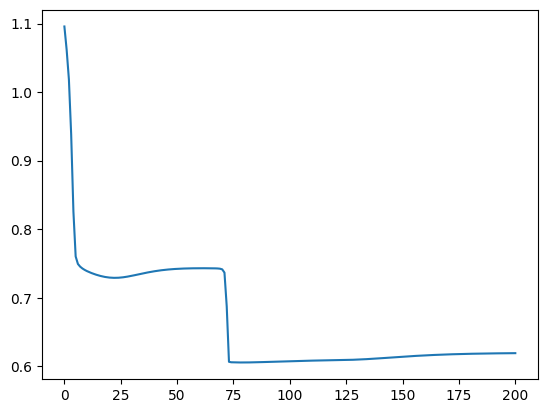

In [29]:
plt.plot(loss)

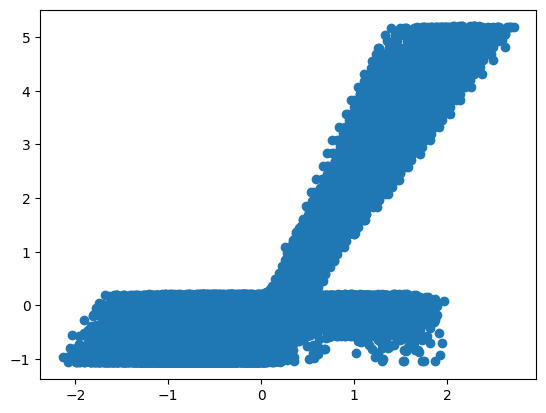

In [30]:
# plot a sample of the encoded data
test = model.encode(X.to('cuda'))
# plot each column against the first
# make a parity
test = test.reshape(-1, 3)

pred = model.decode(test.to('cuda'))
plt.scatter(pred.cpu().detach().numpy().flatten(), X.cpu().detach().numpy().flatten())

In [31]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_error
r2 = r2_score(X.cpu().detach().numpy().flatten(), pred.cpu().detach().numpy().flatten())
mae =  mean_absolute_error(X.cpu().detach().numpy().flatten(), pred.cpu().detach().numpy().flatten())
mse = mean_squared_error(X.cpu().detach().numpy().flatten(), pred.cpu().detach().numpy().flatten())
print('R2: ', r2)
print('MAE: ', mae)
print('MSE: ', mse)

R2:  0.42527461273133216
MAE:  0.5355915
MSE:  0.57472545


In [ ]:
# to do 
# 1. pack for Sanibel, do laundry, 